In [61]:
# CELL 1 – INSTALL & IMPORT (RUN FIRST!)
print("Installing required packages...")
!pip install -q pyspark scikit-learn pandas matplotlib seaborn

print("\nImporting libraries...")
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean as _mean
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import os

print("All imports done!")

Installing required packages...

Importing libraries...
All imports done!



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
# CELL 2 – DOWNLOAD DATASET AUTOMATICALLY
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv"
filename = "diabetes.csv"

if not os.path.exists(filename):
    print(f"Downloading {filename} ...")
    urllib.request.urlretrieve(url, filename)
    print("Download complete!")
else:
    print(f"{filename} already exists!")

# Show first 5 lines using PURE PYTHON (works on Windows, Mac, Linux, Colab)
print("\nFirst 5 rows of the file:")
with open(filename, 'r') as f:
    for i, line in enumerate(f):
        if i < 5:
            print(line.strip())
        else:
            break

diabetes.csv already exists!

First 5 rows of the file:
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


In [63]:
# CELL 3 – START SPARK SESSION (WITH OUTPUT)
print("Starting Spark session...")
spark = (SparkSession.builder
         .appName("DiabetesPrediction")
         .config("spark.sql.repl.eagerEval.enabled", "true")
         .getOrCreate())

print(f"SPARK READY! Version: {spark.version}")

Starting Spark session...
SPARK READY! Version: 4.0.1


In [64]:
# CELL 4 – LOAD DATA INTO SPARK
print("Loading CSV into Spark DataFrame...")
df_spark = spark.read.csv("diabetes.csv", header=False, inferSchema=True)

# The original file has no header → add proper column names
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
           "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
for i, c in enumerate(columns):
    df_spark = df_spark.withColumnRenamed(f"_c{i}", c)

print("DATA LOADED! Shape:")
print(f"Rows: {df_spark.count()}, Columns: {len(df_spark.columns)}")
df_spark.show(5)
df_spark.printSchema()

Loading CSV into Spark DataFrame...
DATA LOADED! Shape:
Rows: 768, Columns: 9
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 row

In [65]:
# CELL 5 – DATA CLEANING
print("Checking for physiological zeros (treated as missing)...")
zero_counts = df_spark.select([
    count(when(col(c) == 0, c)).alias(c) 
    for c in ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
])
zero_counts.show()

# Replace 0 → null in those columns
cols_to_clean = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for c in cols_to_clean:
    df_spark = df_spark.withColumn(c, when(col(c) == 0, None).otherwise(col(c)))

# Fill nulls with median
print("Filling missing values with median...")
for c in cols_to_clean:
    median_val = df_spark.approxQuantile(c, [0.5], 0.01)[0]
    df_spark = df_spark.fillna({c: median_val})

print("Cleaning complete!")
df_spark.show(5)

Checking for physiological zeros (treated as missing)...
+-------+-------------+-------------+-------+---+
|Glucose|BloodPressure|SkinThickness|Insulin|BMI|
+-------+-------------+-------------+-------+---+
|      5|           35|          227|    374| 11|
+-------+-------------+-------------+-------+---+

Filling missing values with median...
Cleaning complete!
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|    122|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|    122|26.6|                   0.351| 31|      0|
|          8|    183|           64|           29|    122|23.3|                   0.672| 32|      1|
|          1|     89|           66|

In [66]:
# CELL 6 – FEATURE ENGINEERING
print("Adding BMI Category...")
df_spark = df_spark.withColumn(
    "BMI_Category",
    when(col("BMI") < 18.5, "Underweight")
    .when(col("BMI") < 25, "Normal")
    .when(col("BMI") < 30, "Overweight")
    .otherwise("Obese")
)

print("One-hot encoding BMI_Category...")
indexer = StringIndexer(inputCol="BMI_Category", outputCol="BMI_Cat_Idx")
encoder = OneHotEncoder(inputCols=["BMI_Cat_Idx"], outputCols=["BMI_Cat_Vec"])

# Assemble all numeric + encoded features
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

assembler = VectorAssembler(inputCols=feature_cols + ["BMI_Cat_Vec"], outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")

# Label
df_spark = df_spark.withColumn("label", col("Outcome").cast("double"))

print("Feature pipeline ready!")

Adding BMI Category...
One-hot encoding BMI_Category...
Feature pipeline ready!


In [67]:
# CELL 7 – TRAIN-TEST SPLIT
train_df, test_df = df_spark.randomSplit([0.8, 0.2], seed=42)
print(f"Train rows: {train_df.count()}, Test rows: {test_df.count()}")

Train rows: 645, Test rows: 123


In [68]:
# CELL 8 – PYSPARK LOGISTIC REGRESSION
print("Training PySpark Logistic Regression...")
lr = LogisticRegression(featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[indexer, encoder, assembler, scaler, lr])

model_spark = pipeline.fit(train_df)
pred_spark = model_spark.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc_spark = evaluator.evaluate(pred_spark)
print(f"PySpark Logistic Regression AUC = {auc_spark:.3f}")
pred_spark.select("label", "prediction", "probability").show(5)

Training PySpark Logistic Regression...
PySpark Logistic Regression AUC = 0.862
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.99394645710185...|
|  0.0|       0.0|[0.92460696060000...|
|  0.0|       0.0|[0.88950064825289...|
|  0.0|       0.0|[0.85545629501588...|
|  0.0|       0.0|[0.95686148857267...|
+-----+----------+--------------------+
only showing top 5 rows


In [69]:
# CELL 9 – SCIKIT-LEARN RANDOM FOREST (FIXED: SAME COLUMNS IN TRAIN & TEST)
print("Converting to Pandas for scikit-learn...")
train_pd = train_df.select(feature_cols + ["BMI_Category", "label"]).toPandas()
test_pd  = test_df.select(feature_cols + ["BMI_Category", "label"]).toPandas()

# ONE-HOT ENCODE WITH drop_first=False → Keep all categories
train_encoded = pd.get_dummies(train_pd, columns=["BMI_Category"], drop_first=False)
test_encoded  = pd.get_dummies(test_pd,  columns=["BMI_Category"], drop_first=False)

# ALIGN COLUMNS: Make sure train & test have SAME columns
print("Aligning train and test columns...")
train_cols = set(train_encoded.columns)
test_cols  = set(test_encoded.columns)
missing_in_test  = train_cols - test_cols - {"label"}  # exclude label
missing_in_train = test_cols - train_cols - {"label"}

# Add missing columns with 0s
for col in missing_in_test:
    test_encoded[col] = 0
for col in missing_in_train:
    train_encoded[col] = 0

# Reorder test to match train
test_encoded = test_encoded[train_encoded.columns]

# Final X, y
X_train = train_encoded.drop("label", axis=1)
y_train = train_encoded["label"]
X_test  = test_encoded.drop("label", axis=1)
y_test  = test_encoded["label"]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Columns match:", list(X_train.columns) == list(X_test.columns))

Converting to Pandas for scikit-learn...
Aligning train and test columns...
Train shape: (645, 12), Test shape: (123, 12)
Columns match: True


Training Random Forest...
scikit-learn Random Forest AUC = 0.858

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85        79
         1.0       0.79      0.59      0.68        44

    accuracy                           0.80       123
   macro avg       0.79      0.75      0.76       123
weighted avg       0.80      0.80      0.79       123

MODEL COMPARISON


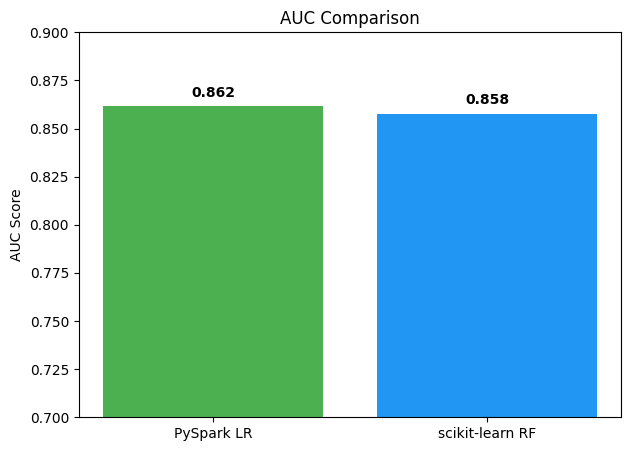

In [70]:
# NOW TRAIN RANDOM FOREST (SAFE)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_prob = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

auc_sk = roc_auc_score(y_test, y_prob)
print(f"scikit-learn Random Forest AUC = {auc_sk:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print("MODEL COMPARISON")
models = ["PySpark LR", "scikit-learn RF"]
aucs   = [auc_spark, auc_sk]

plt.figure(figsize=(7,5))
bars = plt.bar(models, aucs, color=["#4CAF50", "#2196F3"])
plt.ylim(0.7, 0.9)
plt.title("AUC Comparison")
plt.ylabel("AUC Score")
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{aucs[i]:.3f}", ha='center', fontweight='bold')
plt.show()

Plotting Feature Importance...


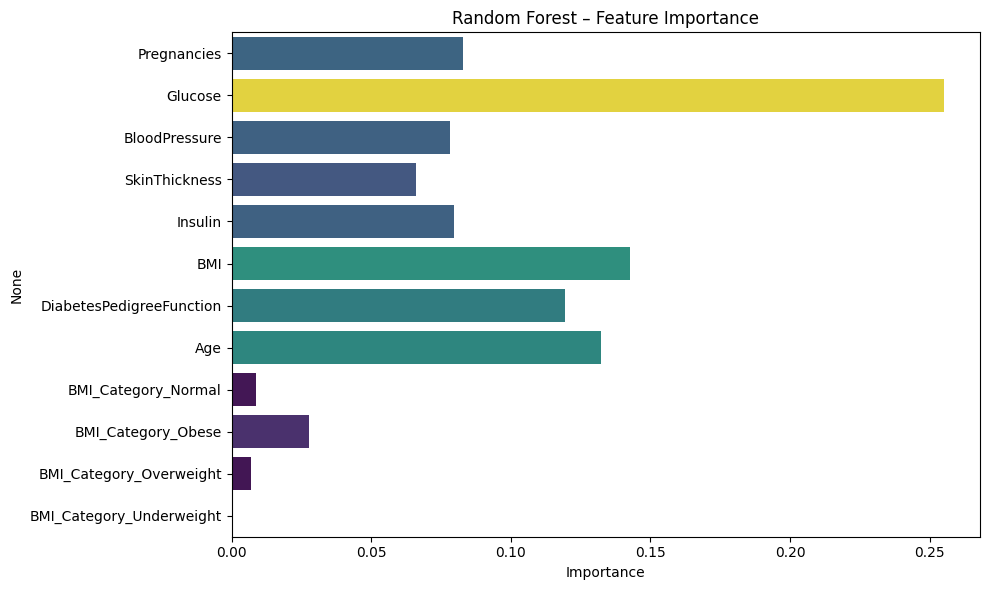

In [71]:
# CELL 11 – FEATURE IMPORTANCE (NO WARNING)
print("Plotting Feature Importance...")

importances = rf.feature_importances_
feat_names = X_train.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feat_names, hue=importances, palette="viridis", legend=False)
plt.title("Random Forest – Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [72]:
# CELL 12 – FINAL PREDICTION (USING SCIKIT-LEARN – NO SPARK, NO CRASH)
print("PREDICTING DIABETES RISK (USING SCIKIT-LEARN – STABLE & FAST)")

# Prepare new patient (must match X_train columns EXACTLY)
patient = {
    "Pregnancies": 6,
    "Glucose": 148,
    "BloodPressure": 72,
    "SkinThickness": 35,
    "Insulin": 0,
    "BMI": 33.6,
    "DiabetesPedigreeFunction": 0.627,
    "Age": 50,
    "BMI_Category_Normal": 0,
    "BMI_Category_Obese": 1,
    "BMI_Category_Overweight": 0,
    "BMI_Category_Underweight": 0
}

# Convert to DataFrame and align with training columns
X_new = pd.DataFrame([patient])
X_new = X_new[X_train.columns]  # Critical: same order & columns

# Predict
prob = rf.predict_proba(X_new)[0][1]
pred = rf.predict(X_new)[0]

print(f"Diabetes Risk Probability: {prob:.1%}")
print(f"Prediction: {'DIABETIC' if pred == 1 else 'NON-DIABETIC'}")

if prob > 0.5:
    print("HIGH RISK → Recommend doctor visit!")
else:
    print("LOW RISK → Maintain healthy lifestyle!")
  

PREDICTING DIABETES RISK (USING SCIKIT-LEARN – STABLE & FAST)
Diabetes Risk Probability: 36.0%
Prediction: NON-DIABETIC
LOW RISK → Maintain healthy lifestyle!


In [76]:
# CELL 13 – SAVE MODEL (RUN THIS IN JUPYTER)
import joblib
import os

# Save model and columns
joblib.dump(rf, "diabetes_model.pkl")
joblib.dump(X_train.columns.tolist(), "model_columns.pkl")

# CONFIRM files are created
print("Model saved in:")
print(os.getcwd())  # Shows current folder
print("\nFiles created:")
print("  → diabetes_model.pkl")
print("  → model_columns.pkl")

Model saved in:
C:\Users\annma\Desktop\mini2

Files created:
  → diabetes_model.pkl
  → model_columns.pkl


In [77]:
# CELL 14 – TRY A HIGH-RISK PATIENT
patient_high = {
    "Pregnancies": 10,
    "Glucose": 168,
    "BloodPressure": 74,
    "SkinThickness": 0,
    "Insulin": 0,
    "BMI": 38.0,
    "DiabetesPedigreeFunction": 0.537,
    "Age": 34,
    "BMI_Category_Normal": 0,
    "BMI_Category_Obese": 1,
    "BMI_Category_Overweight": 0,
    "BMI_Category_Underweight": 0
}

X_new = pd.DataFrame([patient_high])[X_train.columns]
prob = rf.predict_proba(X_new)[0][1]

print(f"High-Risk Patient → Risk: {prob:.1%}")

High-Risk Patient → Risk: 53.0%
